In [1]:
import pandas as pd
import mysql.connector
import os

# List of CSV files and their corresponding table names
csv_files = [
    ('customers.csv', 'customers'),
    ('orders.csv', 'orders'),
    ('sellers.csv', 'sellers'),
    ('products.csv', 'products'),
    ('geolocation.csv', 'geolocation'),
    ('payments.csv', 'payments'),
    ('order_items.csv','order_items')# Added payments.csv for specific handling
]

# Connect to the MySQL database
conn = mysql.connector.connect(
    host='localhost',
    user='root',
    password='Pass@123',
    database='ecommerce'
)
cursor = conn.cursor()

# Folder containing the CSV files
folder_path = 'C:/Users/jadha/OneDrive/Desktop/ecommarce'

def get_sql_type(dtype):
    if pd.api.types.is_integer_dtype(dtype):
        return 'INT'
    elif pd.api.types.is_float_dtype(dtype):
        return 'FLOAT'
    elif pd.api.types.is_bool_dtype(dtype):
        return 'BOOLEAN'
    elif pd.api.types.is_datetime64_any_dtype(dtype):
        return 'DATETIME'
    else:
        return 'TEXT'

for csv_file, table_name in csv_files:
    file_path = os.path.join(folder_path, csv_file)
    
    # Read the CSV file into a pandas DataFrame
    df = pd.read_csv(file_path)
    
    # Replace NaN with None to handle SQL NULL
    df = df.where(pd.notnull(df), None)
    
    # Debugging: Check for NaN values
    print(f"Processing {csv_file}")
    print(f"NaN values before replacement:\n{df.isnull().sum()}\n")

    # Clean column names
    df.columns = [col.replace(' ', '_').replace('-', '_').replace('.', '_') for col in df.columns]

    # Generate the CREATE TABLE statement with appropriate data types
    columns = ', '.join([f'`{col}` {get_sql_type(df[col].dtype)}' for col in df.columns])
    create_table_query = f'CREATE TABLE IF NOT EXISTS `{table_name}` ({columns})'
    cursor.execute(create_table_query)

    # Insert DataFrame data into the MySQL table
    for _, row in df.iterrows():
        # Convert row to tuple and handle NaN/None explicitly
        values = tuple(None if pd.isna(x) else x for x in row)
        sql = f"INSERT INTO `{table_name}` ({', '.join(['`' + col + '`' for col in df.columns])}) VALUES ({', '.join(['%s'] * len(row))})"
        cursor.execute(sql, values)

    # Commit the transaction for the current CSV file
    conn.commit()

# Close the connection
conn.close()

Processing customers.csv
NaN values before replacement:
customer_id                 0
customer_unique_id          0
customer_zip_code_prefix    0
customer_city               0
customer_state              0
dtype: int64

Processing orders.csv
NaN values before replacement:
order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64

Processing sellers.csv
NaN values before replacement:
seller_id                 0
seller_zip_code_prefix    0
seller_city               0
seller_state              0
dtype: int64

Processing products.csv
NaN values before replacement:
product_id                      0
product category              610
product_name_length           610
product_description_length    610
product_photos_qty            610
prod

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import mysql.connector
import numpy as np

db=mysql.connector.connect(host="localhost",
                          username="root",
                          password="Pass@123",
                          database="ecommerce")
cur=db.cursor()


# List all unique cities where customers are located. 

In [8]:
query= """Select distinct customer_city from customers"""

cur.execute(query)

data = cur.fetchall()

df=pd.DataFrame(data,columns=["customer_city"])

df

,customer_city
0,franca
1,sao bernardo do campo
2,sao paulo
3,mogi das cruzes
4,campinas
...,...
4114,siriji
4115,natividade da serra
4116,monte bonito
4117,sao rafael


# Count the number of orders placed in 2017. 

In [10]:
query= """Select count(order_id) from orders where year(order_purchase_timestamp)=2017 """

cur.execute(query)

data = cur.fetchall()

"Total orders placed in 2017 are",data[0][0]

('Total orders placed in 2017 are', 135303)

# Find the total sales per category.


In [12]:
query= """Select upper(products.product_category) as category,round(sum(payments.payment_value),2) as sales
from products join order_items 
on products.product_id=order_items.product_id
join payments 
on payments.order_id=order_items.order_id
group by category
"""

cur.execute(query)

data = cur.fetchall()

df=pd.DataFrame(data,columns=['Category','Sales'])
df



,Category,Sales
0,PERFUMERY,13681943.82
1,FURNITURE DECORATION,38614762.58
2,TELEPHONY,13145815.37
3,FASHION BAGS AND ACCESSORIES,5890273.56
4,BED TABLE BATH,46238949.12
...,...,...
69,CDS MUSIC DVDS,32384.61
70,LA CUISINE,78665.31
71,FASHION CHILDREN'S CLOTHING,21213.09
72,PC GAMER,58709.61


# Calculate the percentage of orders that were paid in installments.

In [14]:
query= """select (sum(case when payment_installments>=1 then 1 else 0 end))/count(*)*100 from payments
"""

cur.execute(query)

data = cur.fetchall()

"The percentage of orders that were paid in installments is",data[0][0]

('The percentage of orders that were paid in installments is',
 Decimal('99.9981'))

# Count the number of customers from each state.

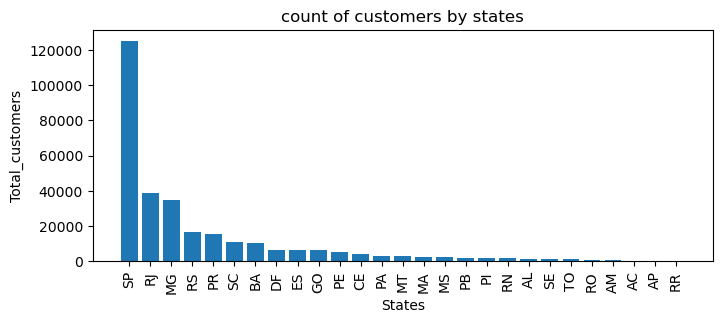

In [16]:
query= """select customer_state,count(customer_id) from customers group by customer_state
"""

cur.execute(query)

data = cur.fetchall()
df=pd.DataFrame(data,columns=["Customer_State","Total_customers"])
df=df.sort_values(by="Total_customers",ascending=False)
#df
plt.figure(figsize=(8,3))
plt.bar(df["Customer_State"],df["Total_customers"])
plt.xticks(rotation=90)
plt.xlabel("States")
plt.ylabel("Total_customers")
plt.title("count of customers by states")
plt.show()

# Calculate the number of orders per month in 2018.

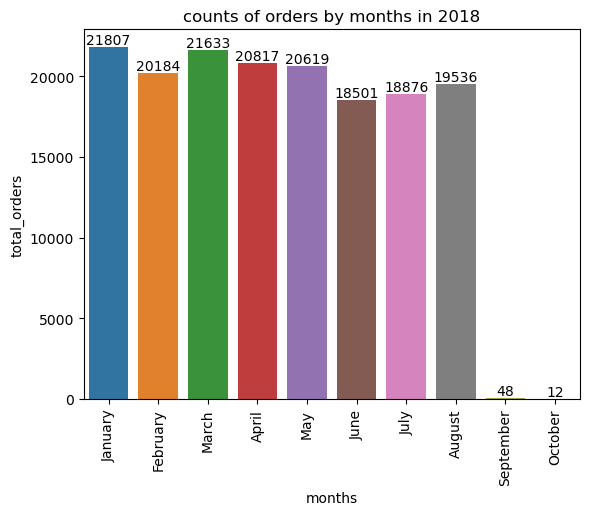

In [18]:
query= """select monthname(order_purchase_timestamp) as months,count(order_id) as total_orders
from orders
where year(order_purchase_timestamp)=2018
group by months
"""

cur.execute(query)

data = cur.fetchall()

df=pd.DataFrame(data,columns=["months","total_orders"])

o=["January","February","March","April","May","June","July","August","September","October"]
#df
ax=sns.barplot(x=df["months"],y=df["total_orders"],data=df,order=o)
plt.xticks(rotation=90)
ax.bar_label(ax.containers[0])
plt.title("counts of orders by months in 2018")
plt.show()

#  Find the average number of products per order, grouped by customer city.

In [20]:
query= """ with count_per_order as
(select orders.order_id, orders.customer_id,count(order_items.order_id) as oc
from orders
join order_items
on orders.order_id=order_items.order_id
group by orders.order_id, orders.customer_id)
select customers.customer_city,round(avg(count_per_order.oc),2) as average_orders
from customers 
join count_per_order
on  customers.customer_id=count_per_order.customer_id
group by customers.customer_city order by average_orders desc;
"""

cur.execute(query)

data = cur.fetchall()

df=pd.DataFrame(data,columns=["city","average_products per order"])
#df
df.head(10)

,city,average_products per order
0,padre carvalho,63.00
1,celso ramos,58.50
2,datas,54.00
3,candido godoi,54.00
4,matias olimpio,45.00
5,cidelandia,36.00
6,curralinho,36.00
7,picarra,36.00
8,morro de sao paulo,36.00
9,teixeira soares,36.00


# Calculate the percentage of total revenue contributed by each product category

In [22]:
query= """Select upper(products.product_category) as category,
round((sum(payments.payment_value)/(select sum(payments.payment_value)from payments))*100,2) as sales_percentage
from products 
join order_items 
on products.product_id=order_items.product_id
join payments 
on payments.order_id=order_items.order_id
group by category
order by sales_percentage desc
"""

cur.execute(query)

data = cur.fetchall()

df=pd.DataFrame(data,columns=['Category','Sales_percentage'])
df


,Category,Sales_percentage
0,BED TABLE BATH,96.28
1,HEALTH BEAUTY,93.18
2,COMPUTER ACCESSORIES,89.13
3,FURNITURE DECORATION,80.40
4,WATCHES PRESENT,80.35
...,...,...
69,PC GAMER,0.12
70,HOUSE COMFORT 2,0.10
71,CDS MUSIC DVDS,0.07
72,FASHION CHILDREN'S CLOTHING,0.04


# Identify the correlation between product price and the number of times a product has been purchased.

In [24]:
query= """select upper(products.product_category),count(order_items.product_id) as order_count,
round(avg(order_items.price),2) as price
from  products
join  order_items
on  products.product_id=order_items.product_id
group by products.product_category
"""

cur.execute(query)

data = cur.fetchall()

df=pd.DataFrame(data,columns=['Category','order_count',"price"])
#df
arr1=df["order_count"]
arr2=df["price"]

a=np.corrcoef([arr1,arr2])
#there is nutral correlation
print("The correlation between price and number of times a product has been purchased",a[0][1])

The correlation between price and number of times a product has been purchased -0.10631514167157562


# Calculate the total revenue generated by each seller, and rank them by revenue.

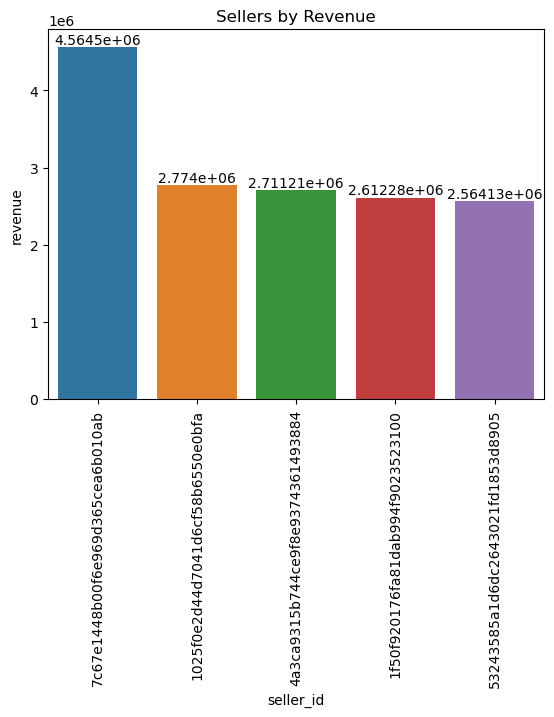

In [26]:
query= """ select *,dense_rank()over(order by revenue desc) as rnk
from
(select order_items.seller_id,round(sum(payments.payment_value),2) as revenue
from  order_items
join  payments
on order_items.order_id=payments.order_id
group by order_items.seller_id) as a
"""

cur.execute(query)

data = cur.fetchall()

df=pd.DataFrame(data,columns=["seller_id","revenue","ranks"])

df=df.head(5)

ax=sns.barplot(x="seller_id",y="revenue",data=df)
ax.bar_label(ax.containers[0])
plt.title("Sellers by Revenue")
plt.xticks(rotation=90)
plt.show()

# Calculate the moving average of order values for each customer over their order history.

In [28]:
query= """select customer_id,order_purchase_timestamp,payment,
avg(payment)over(partition by customer_id order by order_purchase_timestamp rows between 2 preceding and current row) as mov_avg
from
(select orders.customer_id,orders.order_purchase_timestamp,
payments.payment_value as payment
from payments
join orders
on payments.order_id=orders.order_id) as a
"""

cur.execute(query)

data = cur.fetchall()

df=pd.DataFrame(data,columns=["customer_id","order_purchase_timestamp","payment","moving_average"])
df

,customer_id,order_purchase_timestamp,payment,moving_average
0,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
1,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
2,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
3,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
4,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
...,...,...,...,...
934969,ffffe8b65bbe3087b653a978c870db99,2017-09-29 14:07:03,18.37,18.370001
934970,ffffe8b65bbe3087b653a978c870db99,2017-09-29 14:07:03,18.37,18.370001
934971,ffffe8b65bbe3087b653a978c870db99,2017-09-29 14:07:03,18.37,18.370001
934972,ffffe8b65bbe3087b653a978c870db99,2017-09-29 14:07:03,18.37,18.370001


# Calculate the cumulative sales per month for each year.

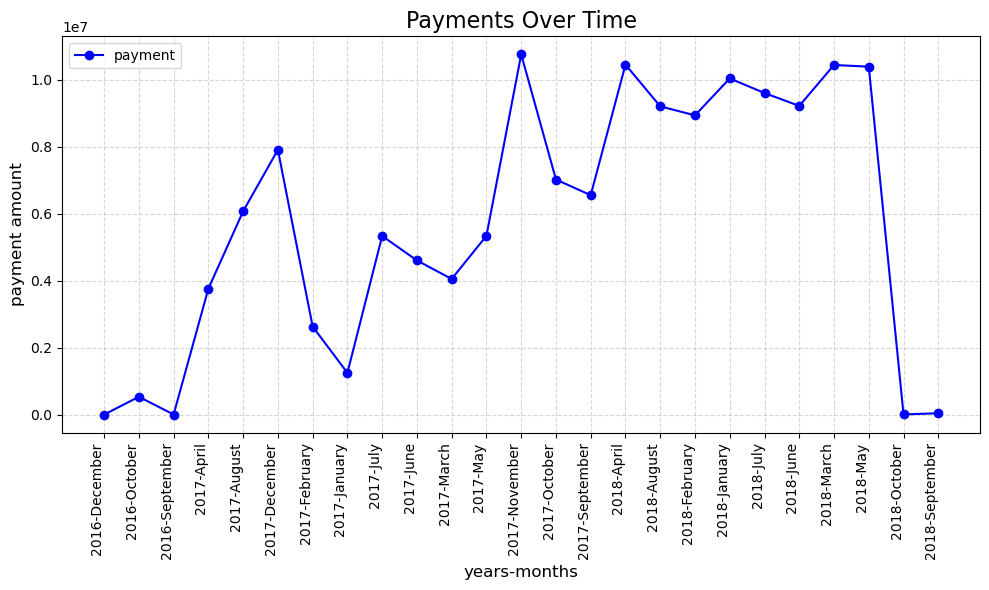

In [30]:
query= """select years,months,payment,round(sum(payment)over(order by years,months),2) as cumulative_sales
from
(select year(orders.order_purchase_timestamp) as years,
monthname(orders.order_purchase_timestamp) as months,
round(sum(payments.payment_value),2) as payment
from  orders
join  payments
on orders.order_id=payments.order_id
group by years,months
order by years,months) as a;
"""

cur.execute(query)

data = cur.fetchall()

df=pd.DataFrame(data,columns=["years","months","payment","cumulative_sales"])

#df
df['years-months']=df['years'].astype(str)+'-'+df['months']
plt.figure(figsize=(10,6))
plt.plot(df["years-months"],df["payment"],marker="o",label="payment",color='b')
plt.title("Payments Over Time",fontsize=16)
plt.xlabel("years-months",fontsize=12)
plt.ylabel("payment amount",fontsize=12)
plt.xticks(rotation=90,ha='right')
plt.grid(True,linestyle='--',alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()

# Calculate the year-over-year growth rate of total sales.

In [32]:
query= """with a as (select year(orders.order_purchase_timestamp) as years,
round(sum(payments.payment_value),2) as payment
from  orders
join  payments
on orders.order_id=payments.order_id
group by years
order by years)
select years,payment,
round(((payment-lag(payment,1)over(order by years))/lag(payment,1)over(order by years))*100,2) as YOY_Growth
 from a ;
"""

cur.execute(query)

data = cur.fetchall()

df=pd.DataFrame(data,columns=["years","payments","YOY_Percentage_Growth"])

df

,years,payments,YOY_Percentage_Growth
0,2016,534261.06,NaN
1,2017,65247720.55,12112.7
2,2018,78297867.47,20.0


# Calculate the retention rate of customers, defined as the percentage of customers who make another purchase within 6 months of their first purchase.

In [34]:
query="""with a  as (select customers.customer_id,
min(orders.order_purchase_timestamp) as first_order
from   customers 
join   orders
on customers.customer_id=orders.customer_id
group by  customers.customer_id),

b as (select a.customer_id,count(distinct orders.order_purchase_timestamp) as next_order
from a
join orders
on orders.customer_id=a.customer_id 
and orders.order_purchase_timestamp>first_order
and orders.order_purchase_timestamp<date_add(first_order,interval 6 month)
group by  a.customer_id)

select 100*(count(distinct a.customer_id)/count(distinct b.customer_id))
from a 
left join b
on  a.customer_id= b.customer_id;"""

cur.execute(query)

data = cur.fetchall()

data

[(None,)]

# since none of are customers are repeated that why are value is none.

# Identify the top 3 customers who spent the most money in each year

In [36]:
query="""select years,customer_id,payment,d_ranks
from
(select year(orders.order_purchase_timestamp) as years,
orders.customer_id,
sum(payments.payment_value) as payment,
dense_rank()over(partition by year(orders.order_purchase_timestamp) order by sum(payments.payment_value) desc) as d_ranks 
from ecommerce.orders
join ecommerce.payments
on payments.order_id=orders.order_id
group by year(orders.order_purchase_timestamp),orders.customer_id) as a
where d_ranks<=3;
"""

cur.execute(query)
data = cur.fetchall()
df=pd.DataFrame(data,columns=["years","customer_id","payment","rank"])
df
# df = pd.DataFrame(data, columns=["years","customer_id","payment","d_rank"])
# sns.barplot(x = "customer_id",y = "payment",data = df,hue = "years")
# plt.xticks(rotation = 90)
# plt.show()

,years,customer_id,payment,rank
0,2016,a9dc96b027d1252bbac0a9b72d837fc6,12811.950439,1
1,2016,1d34ed25963d5aae4cf3d7f3a4cda173,12606.659912,2
2,2016,4a06381959b6670756de02e07b83815f,11050.020264,3
3,2017,1617b1357756262bfa56ab541c47bc16,122976.720703,1
4,2017,c6e2731c5b391845f6800c97401a43a9,62363.790527,2
5,2017,3fd6777bbce08a352fddd04e4a7cc8f6,60539.941406,3
6,2018,ec5b2ba62e574342386871631fafd3fc,65473.918945,1
7,2018,f48d464a0baaea338cb25f816991ab1f,62299.889648,2
8,2018,e0a2412720e9ea4f26c1ac985f6a7358,43284.959473,3
